Motorcycle dataset analysis, found at http://vincentarelbundock.github.io/Rdatasets/datasets.html under 'mcycle'

In [3]:
import os 
os.chdir('../')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import GPy
from het_student_t import HetStudentT
from hetgp import HetGP
from svgp_multi import SVGPMulti
import matplotlib
data_dir = './data_download/'
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 12, 3  # that's default image size for this 

In [5]:
restarts = 10
n_folds = 5
Ms = ['all']#, 100]
#These are just starting values, lengthscales will also be randomized
f_rbf_len = 0.3
f_rbf_var = 0.5
g_rbf_len = 0.5
g_rbf_var = 0.5
# This is the log of mean of the posterior of the scale parameter, so we set it
# to be the log of roughly what we expect the scale parameter to be if it were
# constant
gauss_noise = 0.25
g_mean_val = np.log(gauss_noise)
g_bias_var = None
f_bias_var = None #['mean']
fixZ = True
preopt_scg_iters = 100
preopt_restarts = 3
scg_iters = 50
max_iters = 250
num_samples = 100000
gtol = 1e-5
ftol = 0
xtol = 0
#gauss_dataset_names = []#['elevators1000']#, 'elevators10000']
#stut_dataset_names = ['motorCorrupt', 'elevators1000']#, 'elevators10000']
starting_df = 4.0
optimize_df = True

fold = 0
seed = 0

In [ ]:
np.random.seed(seed)

In [6]:
class Dataset(object):
    def __init__(self, Xtrain, Ytrain, Xtest, Ytest):
        self.Xtrain, self.Ytrain, self.Xtest, self.Ytest = Xtrain, Ytrain, Xtest, Ytest

def load_motorCorrupt(fold, seed):
    #Have merged the training and the test, and then put the header in the same file
    data = pd.read_csv(data_dir + 'mcycle.csv', index_col=0)
    data = data.reindex(np.random.permutation(data.index)) # Randomize so test isn't at the end
    X = data['times'].values[:, None]
    Y = data['accel'].values[:, None]
    X = (X-X.mean(0))/X.std(0)
    Y = (Y-Y.mean(0))/Y.std(0)

    from sklearn.model_selection import KFold
    cv = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    #Stupidly you can't just index it...
    for i, (train, test) in enumerate(cv.split(X)):
        if i==fold:
            training_inds = train
            test_inds = test

    # Corrupt some Y's with larger noise
    corrupt_inds = np.random.permutation(range(X.shape[0]))[:25]
    Y[corrupt_inds] = np.random.randn(*Y[corrupt_inds].shape)*3.5

    Xtrain = X[training_inds, :]
    Ytrain = Y[training_inds, :]
    Xtest = X[test_inds, :]
    Ytest = Y[test_inds, :]

    #Corrupt 20 training Y's with larger noise
    #corrupt_inds = np.random.permutation(range(Xtrain.shape[0]))[:10]
    #Ytrain[corrupt_inds] += np.random.randn(*Ytrain[corrupt_inds].shape)*2.0

    print("training shape: ", Xtrain.shape)
    print("test shape: ", Xtest.shape)
    print("All: ", X.shape)
    print(Xtrain.shape[0] + Xtest.shape[0] - X.shape[0])
    return Dataset(Xtrain=Xtrain, Ytrain=Ytrain, Xtest=Xtest, Ytest=Ytest), corrupt_inds, X, Y

dataset, corrupt_inds, X, Y = load_motorCorrupt(fold, seed)

Xtrain = dataset.Xtrain
Ytrain = dataset.Ytrain
Xtest = dataset.Xtest
Ytest = dataset.Ytest

training shape:  (106, 1)
test shape:  (27, 1)
All:  (133, 1)
0


In [10]:
Xtrain.shape

(106, 1)

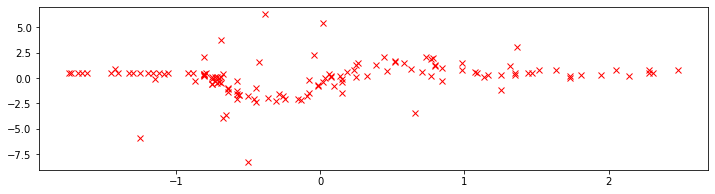

In [7]:
plt.plot(X, Y, 'rx')

In [39]:
def random_multi_lengthscales(X_):
    normed_X = (X_.max(0) - X_.min(0))/X_.std(0)
    # 3 fluctuations in approximately the entire range
    print(normed_X)
    f_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    g_lengthscales = np.random.uniform(size=X_.shape[1])*(0.4/normed_X) + 0.001
    # f_lengthscales = X_.std(0)*np.random.uniform(size=Xtrain.shape[1])*0.05 + 0.001
    # g_lengthscales = X_.std(0)*np.random.uniform(size=Xtrain.shape[1])*0.05 + 0.001
    # f_lengthscales = np.abs(-0.5 + np.random.uniform(size=Xtrain.shape[1])*2.5)
    # g_lengthscales = np.abs(-0.5 + np.random.uniform(size=Xtrain.shape[1])*2.5)
    print(f_lengthscales)
    return f_lengthscales, g_lengthscales

random_multi_lengthscales(Xtrain)

[4.26162431]
[0.00598875]


(array([0.00598875]), array([0.02951905]))

In [12]:
def build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold):
    kernf = GPy.kern.RBF(D, variance=f_rbf_var,
                         lengthscale=np.ones(D)*f_rbf_len, ARD=True,
                         name='kernf_rbf')
    #kernf += GPy.kern.Linear(D, ARD=True, name='kernf_linear')
    kernf += GPy.kern.White(1, variance=0.001, name='f_white')
    if bias is not None:
        if bias == 'mean':
            f_bias_var = dataset.Ytrain.mean()
        else:
            f_bias_var = bias
            kernf += GPy.kern.Bias(1, variance=f_bias_var, name='f_bias')
    kernf.f_white.fix()
    kernf.name = 'kernf'
    return kernf

def build_kerng(D, g_bias, g_rbf_len, seed, fold):
    #Needs white or variance doesn't checkgrad!
    kerng = GPy.kern.RBF(D, variance=g_rbf_var,
                         lengthscale=np.ones(D)*g_rbf_len, ARD=True,
                         name='kerng_rbf')
    kerng += GPy.kern.White(1, variance=0.001, name='g_white')
    if g_bias is not None:
        kerng += GPy.kern.Bias(1, variance=g_bias, name='g_bias')
    kerng.g_white.fix()
    kerng.name = 'kerng'
    return kerng
from scipy.cluster.vq import kmeans as scipy_kmeans

def kmeans(dataset, k, seed):
    Z, _ = scipy_kmeans(dataset.Xtrain, k)
    return Z

def build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold):
    D = dataset.Xtrain.shape[1]
    kernf = build_kernf(D, dataset, bias, f_rbf_len, f_rbf_var, seed, fold)
    m_gauss = GPy.models.SparseGPRegression(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z=Z.copy(), kernel=kernf)
    m_gauss.name='gauss_single'
    m_gauss.likelihood.variance[:] = gauss_noise
    return m_gauss

def preopt_gauss_scheme(m):
    m.kernf.constrain_positive()
    m.likelihood.variance.constrain_positive()
    if hasattr(m, 'Z'):
        m.Z.fix()
    m.optimize('bfgs', max_iters=preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    if hasattr(m, 'Z'):
        m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    return m

def preopt_gauss(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, random_func, seed, fold):
    m = build_gauss_model(dataset, Z, fixZ, bias, f_rbf_len, f_rbf_var, seed, fold)
    print("PreOptimizing gauss ", m)
    print(m.kernf.kernf_rbf.lengthscale)
    best_m = preopt_gauss_scheme(m)
    print("Found best gauss model")
    print(best_m)
    return best_m[:]


In [13]:
#m1.optimize(messages=1)
m1_opt = preopt_gauss(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, random_multi_lengthscales, seed, fold)
m1 = build_gauss_model(dataset, Xtrain.copy(), fixZ, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
m1[:] = m1_opt

reconstraining parameters gauss_single.kernf


PreOptimizing gauss  
Name : gauss_single
Objective : 547.1387815839519
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |     value  |  constraints  |  priors
  inducing_inputs              |  (106, 1)  |               |        
  kernf.kernf_rbf.variance     |       0.5  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |       0.3  |      +ve      |        
  kernf.f_white.variance       |     0.001  |   +ve fixed   |        
  Gaussian_noise.variance      |      0.25  |      +ve      |        
  index  |  gauss_single.kernf.kernf_rbf.lengthscale  |  constraints  |  priors
  [0]    |                                0.30000000  |      +ve      |        


reconstraining parameters gauss_single.Gaussian_noise.variance


Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    01s18  011   2.056696e+02   3.918109e-02 
    02s23  020   2.056428e+02   3.426822e-04 
    04s11  036   2.056415e+02   2.214170e-07 
Runtime:     04s11
Optimization status: Converged

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s13  001   2.056415e+02   2.214173e-07 
    00s44  004   2.056415e+02   7.562214e-08 
Runtime:     00s44
Optimization status: Converged

Found best gauss model

Name : gauss_single
Objective : 205.64150269567088
Number of Parameters : 110
Number of Optimization Parameters : 110
Updates : True
Parameters:
  gauss_single.                |                  value  |  constraints  |  priors
  inducing_inputs              |               (106, 1)  |               |        
  kernf.kernf_rbf.variance     |    0.33207123310681164  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |     0.2801555248277793  |      +ve 

{'inducing': <matplotlib.collections.PathCollection at 0x7f4573ccc080>,
 'dataplot': [<matplotlib.collections.PathCollection at 0x7f4573ccc208>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f4573ccc400>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f4573ccc9e8>]}

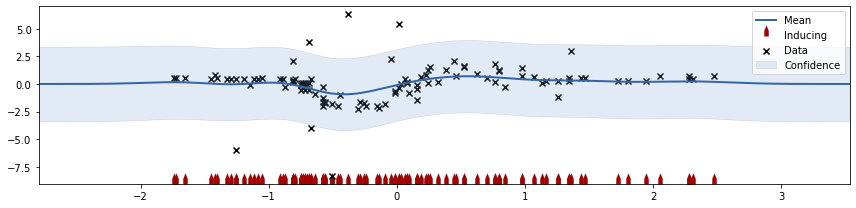

In [14]:
m1.plot()

In [15]:
print(m1)


Name : gauss_single
Objective : 205.64150269567088
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |                  value  |  constraints  |  priors
  inducing_inputs              |               (106, 1)  |               |        
  kernf.kernf_rbf.variance     |    0.33207123310681164  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |     0.2801555248277793  |      +ve      |        
  kernf.f_white.variance       |  1.595667685209428e-08  |   +ve fixed   |        
  Gaussian_noise.variance      |      2.633496235775604  |      +ve      |        


In [16]:
# Make the kernels : 
D = dataset.Xtrain.shape[1]
kernf = build_kernf(D, dataset, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
kerng = build_kerng(D, g_bias_var, g_rbf_len, seed, fold)
kern = [kernf, kerng]

# Multiple latent process model : 
if g_mean_val is not None:
    g_mean = GPy.mappings.Constant(input_dim=13, output_dim=1, value=g_mean_val)
    print(g_mean)
mean_functions = [None, g_mean]
likelihood = HetGP()

Z = dataset.Xtrain.copy()
# Make the model : 
m2 = SVGPMulti(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z.copy(), kern_list=kern,
                    likelihood=likelihood, mean_functions=mean_functions, name='multi_gauss')


def pretrain_multi(m, randomize=True):
    if randomize:
        f_lens, g_lens = random_multi_lengthscales(m.X.values)
        m.kernf.kernf_rbf.lengthscale[:] = f_lens
        m.kernf.kernf_rbf.variance[:] = f_rbf_var
        m.kerng.kerng_rbf.lengthscale[:] = g_lens
        m.kerng.kerng_rbf.variance[:] = g_rbf_var
    m.kernf.fix()
    m.kerng.fix()
    if hasattr(m, 'Z'):
        m.Z.fix()
    if hasattr(m, 'constmap'):
        m.constmap.fix()
    print(m)

    #Optimize model with fixed parameters to get latent functions in place
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    #Constrain all kernel parameters positive and reoptimize
    m.kernf.constrain_positive()
    m.kerng.constrain_positive()
    m.kernf.f_white.fix()
    m.kerng.g_white.fix()
    if hasattr(m, 'constmap'):
        m.constmap.unfix()

    # Continue with optimization with everything released
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    #if hasattr(m, 'Z'):
    #    m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)

    return m

m2 = pretrain_multi(m2)

  constmap.  |                value  |  constraints  |  priors
  C          |  -1.3862943611198906  |               |        
[4.26162431]
[0.07728751]

Name : multi_gauss
Objective : 43334.68730298303
Number of Parameters : 11667
Number of Optimization Parameters : 11554
Updates : True
Parameters:
  multi_gauss.                 |                value  |  constraints  |  priors
  inducing_inputs              |             (106, 1)  |     fixed     |        
  q_u_means                    |             (106, 2)  |               |        
  qf_u_chols                   |            (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |                  0.5  |   +ve fixed   |        
  kernf.kernf_rbf.lengthscale  |   0.0772875059361838  |   +ve fixed   |        
  kernf.f_white.variance       |                0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |                  0.5  |   +ve fixed   |        
  kerng.kerng_rbf.lengthscale  |  0.0441675309059309

reconstraining parameters multi_gauss.kernf
reconstraining parameters multi_gauss.kerng



Runtime:     05s55
Optimization status: maxiter exceeded

Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s19  004   2.059396e+02   2.579141e+03 
    03s25  076   1.884096e+02   3.311413e+02 
    11s45  264   1.783013e+02   1.407858e+02 
    13s09  302   1.765506e+02   1.863773e+02 
Runtime:     13s09
Optimization status: maxiter exceeded

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s09  001   1.765506e+02   1.721386e+02 
    00s19  003   1.765043e+02   3.415136e+02 
    01s22  026   1.743135e+02   1.052682e+02 
    05s28  115   1.667902e+02   1.184693e+01 
    08s41  171   1.650203e+02   1.431427e+01 
    20s71  439   1.628697e+02   2.896499e-01 
    24s63  502   1.628604e+02   1.192775e-01 
Runtime:     24s63
Optimization status: Maximum number of f evaluations reached



In [17]:
print(m2)


Name : multi_gauss
Objective : 162.8603617166998
Number of Parameters : 11667
Number of Optimization Parameters : 11559
Updates : True
Parameters:
  multi_gauss.                 |                 value  |  constraints  |  priors
  inducing_inputs              |              (106, 1)  |     fixed     |        
  q_u_means                    |              (106, 2)  |               |        
  qf_u_chols                   |             (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |    0.8557326433093436  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |   0.37580176661406056  |      +ve      |        
  kernf.f_white.variance       |                 0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |     2.849706641899188  |      +ve      |        
  kerng.kerng_rbf.lengthscale  |  0.010821692042714576  |      +ve      |        
  kerng.g_white.variance       |                 0.001  |   +ve fixed   |        
  constmap.C                   |

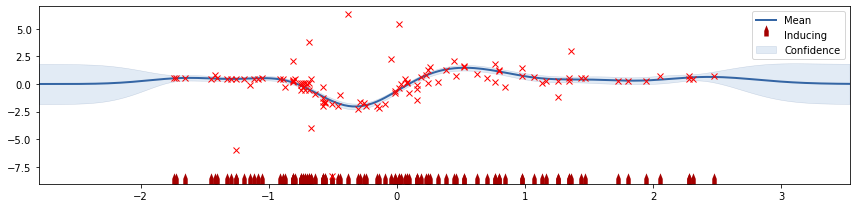

In [18]:
m2.plot_f()
plt.plot(Xtrain, Ytrain, 'rx')

In [19]:
# Make the kernels
D = dataset.Xtrain.shape[1]
kernf = build_kernf(D, dataset, f_bias_var, f_rbf_len, f_rbf_var, seed, fold)
kerng = build_kerng(D, g_bias_var, g_rbf_len, seed, fold)
kern = [kernf, kerng]

# Multiple latent process model
if g_mean_val is not None:
    g_mean = GPy.mappings.Constant(input_dim=13, output_dim=1, value=g_mean_val)
    print(g_mean)
mean_functions = [None, g_mean]
likelihood = HetGP()

Z = dataset.Xtrain.copy()
# Make the model
likelihood = HetStudentT(deg_free=starting_df)
m3 = SVGPMulti(dataset.Xtrain.copy(), dataset.Ytrain.copy(), Z.copy(), kern_list=kern,
                    likelihood=likelihood, mean_functions=mean_functions, name='multi_stut')


def pretrain_multi(m, randomize=True):
    if randomize:
        f_lens, g_lens = random_multi_lengthscales(m.X.values)
        m.kernf.kernf_rbf.lengthscale[:] = f_lens
        m.kernf.kernf_rbf.variance[:] = f_rbf_var
        m.kerng.kerng_rbf.lengthscale[:] = g_lens
        m.kerng.kerng_rbf.variance[:] = g_rbf_var
    m.kernf.fix()
    m.kerng.fix()
    if hasattr(m, 'Z'):
        m.Z.fix()
    if hasattr(m, 'constmap'):
        m.constmap.fix()
    print(m)

    # Optimize model with fixed parameters to get latent functions in place
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    # Constrain all kernel parameters positive and reoptimize
    m.kernf.constrain_positive()
    m.kerng.constrain_positive()
    m.kernf.f_white.fix()
    m.kerng.g_white.fix()
    if hasattr(m, 'constmap'):
        m.constmap.unfix()

    # Continue with optimization with everything released
    m.optimize('scg', max_iters=1*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)
    #if hasattr(m, 'Z'):
    #    m.Z.unfix()
    m.optimize('bfgs', max_iters=5*preopt_scg_iters, gtol=gtol, messages=1, xtol=xtol, ftol=ftol)

    return m

m3 = pretrain_multi(m3)

  constmap.  |                value  |  constraints  |  priors
  C          |  -1.3862943611198906  |               |        
[4.26162431]
[0.0220377]

Name : multi_stut
Objective : 41553.32561855653
Number of Parameters : 11668
Number of Optimization Parameters : 11554
Updates : True
Parameters:
  multi_stut.                  |                value  |  constraints  |  priors
  inducing_inputs              |             (106, 1)  |     fixed     |        
  Hetro_Student_T.deg_free     |                  4.0  |   +ve fixed   |        
  q_u_means                    |             (106, 2)  |               |        
  qf_u_chols                   |            (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |                  0.5  |   +ve fixed   |        
  kernf.kernf_rbf.lengthscale  |  0.02203770189463867  |   +ve fixed   |        
  kernf.f_white.variance       |                0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |                  0.5 

reconstraining parameters multi_stut.kernf
reconstraining parameters multi_stut.kerng


Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s15  003   1.885120e+02   5.440975e+02 
    03s23  066   1.820932e+02   1.810950e+02 
    09s36  192   1.762656e+02   1.004182e+02 
    14s86  302   1.725428e+02   1.060028e+02 
Runtime:     14s86
Optimization status: maxiter exceeded

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s17  002   4.946497e+02   1.725576e+06 
    02s22  033   1.703413e+02   9.278777e+01 
    07s37  133   1.611202e+02   4.535299e+01 
    09s42  173   1.596550e+02   1.042147e+01 
    26s27  502   1.588896e+02   3.399454e-01 
Runtime:     26s27
Optimization status: Maximum number of f evaluations reached



In [20]:
m1.Z.unfix()
m2.Z.unfix()
m3.Z.unfix()
m1.optimize('bfgs', max_iters=3000, messages=1)
print(m1)
m2.optimize('bfgs', max_iters=3000, messages=1)
print(m2)
m3.optimize('bfgs', max_iters=3000, messages=1)
print(m3)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s45  0004   2.056415e+02   3.068336e-08 
Runtime:     00s45
Optimization status: Converged


Name : gauss_single
Objective : 205.64150267959113
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |                  value  |  constraints  |  priors
  inducing_inputs              |               (106, 1)  |               |        
  kernf.kernf_rbf.variance     |     0.3320886070928177  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |     0.2801401452273216  |      +ve      |        
  kernf.f_white.variance       |  1.595667685209428e-08  |   +ve fixed   |        
  Gaussian_noise.variance      |      2.633520849254744  |      +ve      |        
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s82  0005   1.628604e+02   2.579087e+00 
Runtime:     00s82
Optimiza

 /home/rbarbano/projects/dev/ChainedGP/chained_gp/svgp_multi.py:111: RuntimeWarning:overflow encountered in add


    54s03  0303   1.588759e+02   8.112944e+00 
 02m34s54  0857   1.587815e+02   6.351090e+00 
 07m12s45  2399   1.579459e+02   7.428036e+00 
 09m01s49  3002   1.572953e+02   1.505227e+01 
Runtime:  09m01s49
Optimization status: Maximum number of f evaluations reached


Name : multi_stut
Objective : 157.29526588855597
Number of Parameters : 11668
Number of Optimization Parameters : 11665
Updates : True
Parameters:
  multi_stut.                  |                value  |  constraints  |  priors
  inducing_inputs              |             (106, 1)  |               |        
  Hetro_Student_T.deg_free     |                  4.0  |   +ve fixed   |        
  q_u_means                    |             (106, 2)  |               |        
  qf_u_chols                   |            (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |   0.6136013120785809  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |   0.3648934072003797  |      +ve      |        
  kernf.f_white.

In [21]:
m3_free_df = m3.copy()
m3_free_df.Z.fix()
m3_free_df.likelihood.deg_free.constrain_positive()
m3_free_df.optimize('scg', messages=1, max_iters=50)

reconstraining parameters multi_stut.Hetro_Student_T.deg_free


Running Scaled Conjugate Gradients Code:
  runtime   i    f              |g|        
    00s18  04   1.571933e+02   2.951512e+01 
    03s25  68   1.491560e+02   4.167358e+01 
    07s37  152   1.467242e+02   2.055563e+02 
Runtime:     07s37
Optimization status: maxiter exceeded



In [22]:
#m3_free_df.Z.unfix()
m3_free_df.optimize('scg', messages=1, max_iters=200)
m3_free_df.optimize('bfgs', messages=1, max_iters=2000)

Running Scaled Conjugate Gradients Code:
  runtime   i     f              |g|        
    00s15  005   1.466016e+02   1.352235e+02 
    00s18  006   1.466016e+02   1.352227e+02 
    03s25  074   1.453977e+02   2.839571e+01 
    12s62  263   1.419477e+02   3.270984e+01 
    15s76  326   1.414177e+02   1.006152e+01 
    29s79  602   1.409782e+02   3.458822e+00 
Runtime:     29s79
Optimization status: maxiter exceeded

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s16  0002   4.655174e+02   2.271255e+06 
    02s21  0040   1.409281e+02   1.993145e+00 
    08s28  0152   1.407181e+02   7.617514e-01 
    12s36  0229   1.406795e+02   1.184450e-01 
    31s80  0675   1.405359e+02   7.752908e-02 
    37s92  0795   1.405211e+02   5.500114e-02 
    44s15  0912   1.405182e+02   2.122694e-03 
Runtime:     44s15
Optimization status: Converged



In [23]:
m3_free_df

multi_stut.,value,constraints,priors
inducing inputs,"(106, 1)",fixed,
Hetro_Student_T.deg_free,1.1291259923240928,+ve,
q_u_means,"(106, 2)",,
qf_u_chols,"(5671, 2)",,
kernf.kernf_rbf.variance,0.7288405083287266,+ve,
kernf.kernf_rbf.lengthscale,0.3128533559317565,+ve,
kernf.f_white.variance,0.001,+ve fixed,
kerng.kerng_rbf.variance,2.4758147172865153,+ve,
kerng.kerng_rbf.lengthscale,0.8954770671347996,+ve,
kerng.g_white.variance,0.001,+ve fixed,


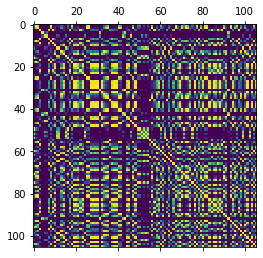

In [24]:
plt.matshow(m3.kernf.K(m3.X))

In [26]:
print(m1)


Name : gauss_single
Objective : 205.64150267959113
Number of Parameters : 110
Number of Optimization Parameters : 109
Updates : True
Parameters:
  gauss_single.                |                  value  |  constraints  |  priors
  inducing_inputs              |               (106, 1)  |               |        
  kernf.kernf_rbf.variance     |     0.3320886070928177  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |     0.2801401452273216  |      +ve      |        
  kernf.f_white.variance       |  1.595667685209428e-08  |   +ve fixed   |        
  Gaussian_noise.variance      |      2.633520849254744  |      +ve      |        


In [27]:
print(m2)


Name : multi_gauss
Objective : 162.86036171670025
Number of Parameters : 11667
Number of Optimization Parameters : 11665
Updates : True
Parameters:
  multi_gauss.                 |                 value  |  constraints  |  priors
  inducing_inputs              |              (106, 1)  |               |        
  q_u_means                    |              (106, 2)  |               |        
  qf_u_chols                   |             (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |    0.8557326433093436  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |   0.37580176661406056  |      +ve      |        
  kernf.f_white.variance       |                 0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |    2.8497066418991883  |      +ve      |        
  kerng.kerng_rbf.lengthscale  |  0.010821692042714576  |      +ve      |        
  kerng.g_white.variance       |                 0.001  |   +ve fixed   |        
  constmap.C                   

In [28]:
print(m3)


Name : multi_stut
Objective : 157.29526588855597
Number of Parameters : 11668
Number of Optimization Parameters : 11665
Updates : True
Parameters:
  multi_stut.                  |                value  |  constraints  |  priors
  inducing_inputs              |             (106, 1)  |               |        
  Hetro_Student_T.deg_free     |                  4.0  |   +ve fixed   |        
  q_u_means                    |             (106, 2)  |               |        
  qf_u_chols                   |            (5671, 2)  |               |        
  kernf.kernf_rbf.variance     |   0.6136013120785809  |      +ve      |        
  kernf.kernf_rbf.lengthscale  |   0.3648934072003797  |      +ve      |        
  kernf.f_white.variance       |                0.001  |   +ve fixed   |        
  kerng.kerng_rbf.variance     |   1.4304502391184875  |      +ve      |        
  kerng.kerng_rbf.lengthscale  |  0.43064251506195195  |      +ve      |        
  kerng.g_white.variance       |          

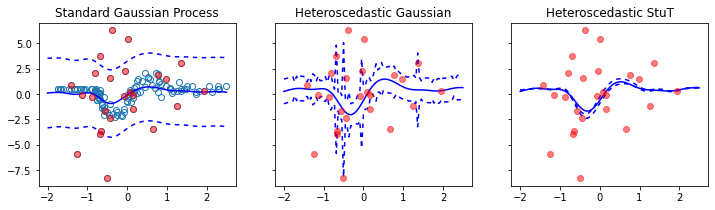

In [40]:
sort_inds = X.argsort(axis=0)
X_sorted = X[sort_inds].reshape(X.shape[0], 1)
Y_sorted = Y[sort_inds].reshape(X.shape[0], 1)


X_full = np.linspace(-2, 2.5, 100)[:, None]
mu_gauss, var_gauss = m1.predict(X_full)
mu_multi_gauss, _ = m2._raw_predict(X_full, 0)
var_multi_gauss, _ = m2._raw_predict(X_full, 1)
mu_multi_stut, _ = m3._raw_predict(X_full, 0)
var_multi_stut, _ = m3._raw_predict(X_full, 1)
mu_multi_stut_free_df, _ = m3_free_df._raw_predict(X_full, 0)
var_multi_stut_free_df, _ = m3_free_df._raw_predict(X_full, 1)

# outlier = Y_sorted > (mu_multi_stut + 3*np.sqrt(np.exp(var_multi_stut)))
dashes = (3,3)
calpha = 0.5
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.plot(X_sorted, Y_sorted, 'o', mfc='none')
ax1.plot(X_full, mu_gauss, 'b-')
ax1.plot(X_full, mu_gauss + 2*np.sqrt(var_gauss), 'b--', dashes=dashes)
ax1.plot(X_full, mu_gauss - 2*np.sqrt(var_gauss), 'b--', dashes=dashes)
ax1.set_title('Standard Gaussian Process')
ax1.plot(X[corrupt_inds], Y[corrupt_inds], 'ro', alpha=calpha)

ax2.plot(X_sorted, Y_sorted, 'o', mfc='none', alpha=0.01)
ax2.plot(X_full, mu_multi_gauss, 'b-')
ax2.plot(X_full, mu_multi_gauss + 2*np.sqrt(np.exp(var_multi_gauss)), 'b--', dashes=dashes)
ax2.plot(X_full, mu_multi_gauss - 2*np.sqrt(np.exp(var_multi_gauss)), 'b--', dashes=dashes)
ax2.set_title('Heteroscedastic Gaussian')
ax2.plot(X[corrupt_inds], Y[corrupt_inds], 'ro', alpha=calpha)

# With df free
ax3.plot(X_sorted, Y_sorted, 'o', mfc='none', alpha=0.01)
ax3.plot(X_full, mu_multi_stut, 'b-')
df = m3_free_df.likelihood.deg_free
real_multi_stut_var = (df / (df - 2.0))*np.exp(var_multi_stut_free_df)
ax3.plot(X_full, mu_multi_stut_free_df + real_multi_stut_var, 'b--', dashes=dashes)
ax3.plot(X_full, mu_multi_stut_free_df - real_multi_stut_var, 'b--', dashes=dashes)
ax3.set_title('Heteroscedastic StuT')
ax3.plot(X[corrupt_inds], Y[corrupt_inds], 'ro', alpha=calpha)

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)
ax3.xaxis.set_major_locator(loc)